In [1]:
# 繪圖設定字體顏色(否則黑色會看不到)
import matplotlib as mpl
COLOR1 = 'red'
COLOR2 = 'blue'
mpl.rcParams['text.color'] = COLOR1
mpl.rcParams['axes.labelcolor'] = COLOR2
mpl.rcParams['xtick.color'] = COLOR2
mpl.rcParams['ytick.color'] = COLOR2

# SVM：PCA降維 x SVM模型訓練辨識是哪張人臉

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.84      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.85       322
        macro avg       0.87      0.72      0.77       322
     weighted avg       0.86      0.85      0.84       322

[[  6   2   0   5   0   0   0]
 [  1  53   1   4   0   1   

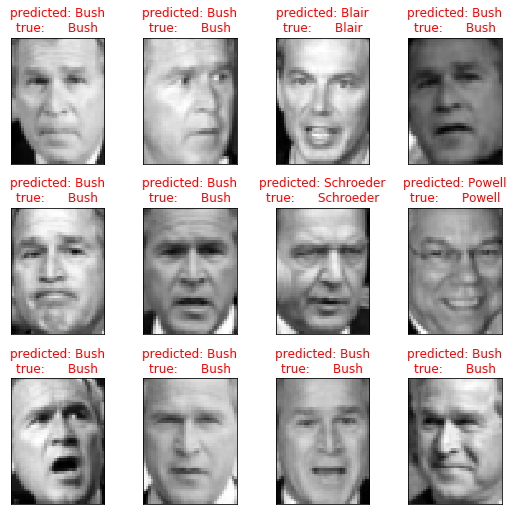

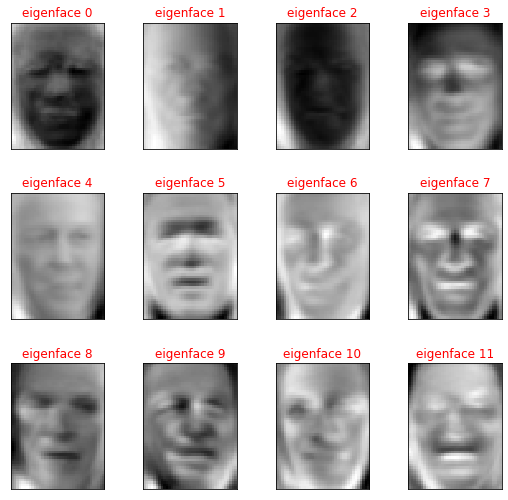

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# LFW人臉資料庫(如果沒有會下載)
    # http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
    # 下載位置：C:\Users\user\scikit_learn_data\lfw_home
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# shape=(1288, 50, 37)
n_samples, h, w = lfw_people.images.shape
# 已打平input：shape=(1288, 50*37=1850)
X = lfw_people.data
n_features = X.shape[1]

# label是人的id(共7個人)，shape=(1288,)
y = lfw_people.target
# array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
#        'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)    # 1288
print("n_features: %d" % n_features)  # 1850
print("n_classes: %d" % n_classes)    # 7
# #############################################################################
# Split into a training set and a test set using a stratified k fold
    # X_train shape=(966, 1850)
    # X_test shape=(322, 1850)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
# #############################################################################
# PCA找 辨識最佳的 150張特徵臉，利用150張特徵臉權重 辨識是哪個人的臉
n_components = 150
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))  # 150張特徵臉 (150, 1850) → (150, 50, 37)
X_train_pca = pca.transform(X_train)                        # shape=(966, 150)
X_test_pca = pca.transform(X_test)                          # shape=(322, 150)
# #############################################################################
# 訓練 Train a SVM classification model：GridSearchCV找到最佳參數
print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
# #############################################################################
# 評估 Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

# 預測和實際的結果，回傳str → 用在繪圖title
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
# 測試資料集 預測322個id，轉成 預測和實際的結果 的字串list
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]

# 測試資料集 繪圖前面12張
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
plot_gallery(X_test, prediction_titles, h, w)

# 繪圖前面12張 特徵臉
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

# OpenCV-影像辨識-使用特徵檔

(-0.5, 511.5, 511.5, -0.5)

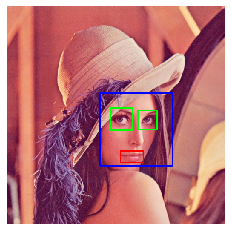

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
# 載入圖片 + 前處理
img = cv2.imread('data/lena.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 引進 正面臉、眼睛、微笑 辨識資料
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('data/haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier('data/haarcascade_smile.xml')
# 檢測圖片中所有人臉(可多張)，並用vector保存各人臉的坐標、大小(矩形表示)
    # 回傳[第一張臉[x, y, w, h], 第二張臉...]
        # x, y 為 框左上角座標
        # w, h 為 框寬高
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x, y, w, h) in faces:
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)               # B畫出臉部
    # 抓出臉部
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)        # 眼睛部分
    smile = smile_cascade.detectMultiScale(roi_gray)     # 微笑部分
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)     # G眼睛
    i = 0
    # 微笑
    for (ex, ey, ew, eh) in smile:
        if i == 0:
            cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 0, 255), 2)  # R微笑
        i += 1
# plt
imageRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imageRGB)
plt.axis('off')

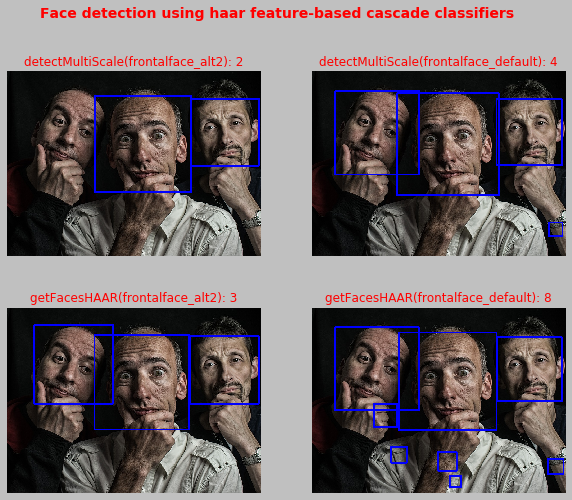

In [12]:
# 比較 2種方法 * 2種前臉xml
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2

# 載入圖片
img = cv2.imread('data/test_face_detection.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# CascadeClassifier
    # 回傳[第一張臉[x, y, w, h], 第二張臉...]
cas_alt2 = cv2.CascadeClassifier(
    "0.data/Face_Detection with_Deep Learning_in_Keras/haarcascade_frontalface_alt2.xml")
cas_default = cv2.CascadeClassifier(
    "0.data/Face_Detection with_Deep Learning_in_Keras/haarcascade_frontalface_default.xml")
faces_alt2 = cas_alt2.detectMultiScale(gray)
faces_default = cas_default.detectMultiScale(gray)

# getFacesHAAR
    # np.squeeze刪除所有維度1
    # 回傳 是否有臉, [第一張臉[x, y, w, h], 第二張臉...]
retval_alt2, faces_haar_alt2 = cv2.face.getFacesHAAR(
    img, "0.data/Face_Detection with_Deep Learning_in_Keras/haarcascade_frontalface_alt2.xml")
faces_haar_alt2 = np.squeeze(faces_haar_alt2)
retval_default, faces_haar_default = cv2.face.getFacesHAAR(
    img, "0.data/Face_Detection with_Deep Learning_in_Keras/haarcascade_frontalface_default.xml")
faces_haar_default = np.squeeze(faces_haar_default)

# 畫框
def show_detection(image, faces):
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 5)
    return image
img_faces_alt2 = show_detection(img.copy(), faces_alt2)
img_faces_default = show_detection(img.copy(), faces_default)
img_faces_haar_alt2 = show_detection(img.copy(), faces_haar_alt2)
img_faces_haar_default = show_detection(img.copy(), faces_haar_default)

# 繪圖
fig = plt.figure(figsize=(10, 8))
plt.suptitle("Face detection using haar feature-based cascade classifiers", fontsize=14, fontweight='bold')
fig.patch.set_facecolor('silver')
def show_img_with_matplotlib(color_img, title, pos):
    img_RGB = color_img[:, :, ::-1]
    ax = plt.subplot(2, 2, pos)
    plt.imshow(img_RGB)
    plt.title(title)
    plt.axis('off')
show_img_with_matplotlib(img_faces_alt2, "detectMultiScale(frontalface_alt2): " + str(len(faces_alt2)), 1)
show_img_with_matplotlib(img_faces_default, "detectMultiScale(frontalface_default): " + str(len(faces_default)), 2)
show_img_with_matplotlib(img_faces_haar_alt2, "getFacesHAAR(frontalface_alt2): " + str(len(faces_haar_alt2)), 3)
show_img_with_matplotlib(img_faces_haar_default, "getFacesHAAR(frontalface_default): " + str(len(faces_haar_default)),4)
plt.show()

scaleFactor=1.05, minNeighbor=2
scaleFactor=1.1, minNeighbor=2
scaleFactor=1.5, minNeighbor=2
scaleFactor=1.05, minNeighbor=5
scaleFactor=1.1, minNeighbor=5
scaleFactor=1.5, minNeighbor=5
scaleFactor=1.05, minNeighbor=10
scaleFactor=1.1, minNeighbor=10
scaleFactor=1.5, minNeighbor=10


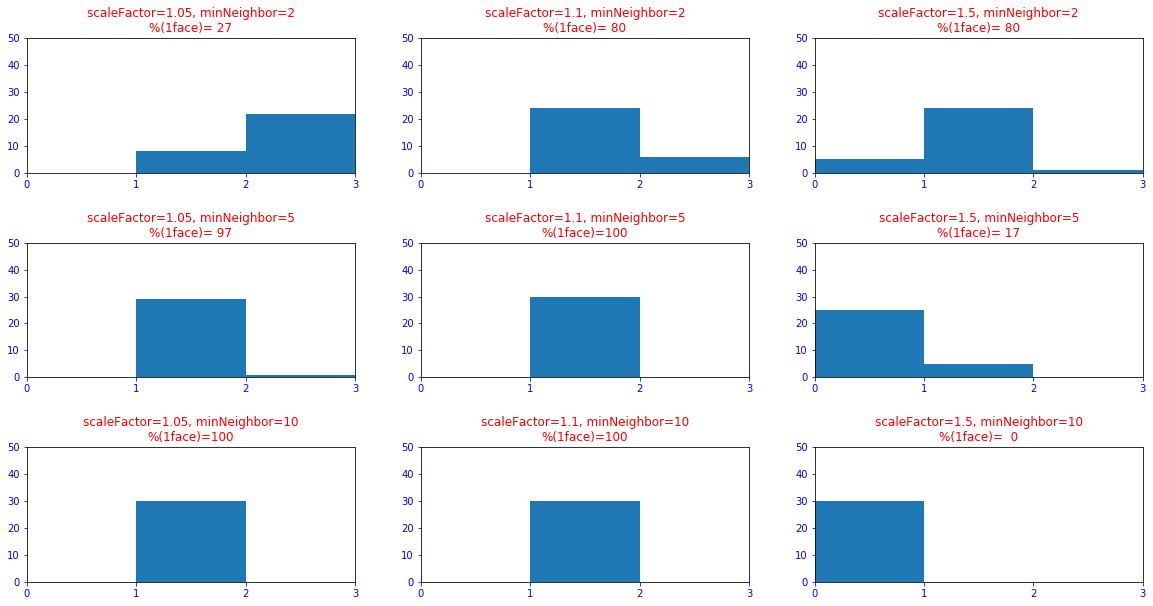

best scaleFactor=1.1, minNeighbor=10


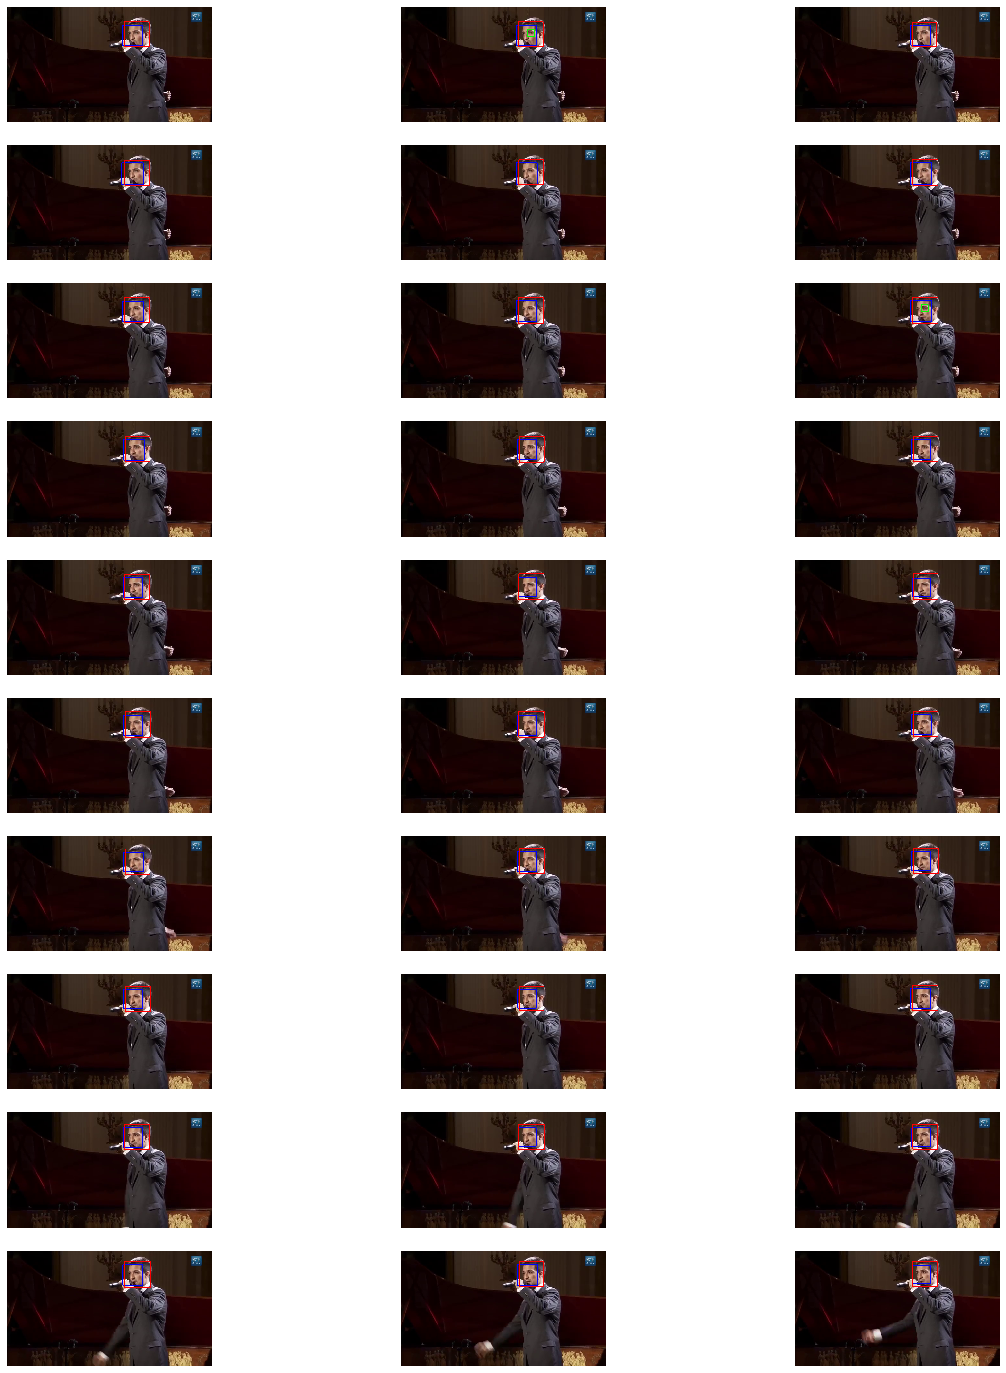

In [32]:
# 參數調校
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.patches as mpatches

# 影片中擷取30幀(張)影像
max_frames = 30
cap = cv2.VideoCapture('data/hamilton_clip.mp4')
frames = []
while cap.isOpened() and max_frames > 0:    
    ret, frame = cap.read()
    frames.append(frame)
    max_frames -= 1

# CascadeClassifier：前臉、眼睛、側臉
haar_face_cascade = cv2.CascadeClassifier(
    './0.data/Face_Detection with_Deep Learning_in_Keras/haarcascade_frontalface_default.xml')
haar_eye_cascade = cv2.CascadeClassifier(
    './0.data/Face_Detection with_Deep Learning_in_Keras/haarcascade_eye.xml')
haar_profile_cascade = cv2.CascadeClassifier(
    './0.data/Face_Detection with_Deep Learning_in_Keras/haarcascade_profileface.xml')

# 取得框 辨識資料：[第一張(x, y, w, h), 第二張(x, y, w, h), ...]
def get_bounding_box(img, cascade, scaleFactor=None, minNeighbors=None):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = np.array(gray_img, dtype='uint8')
    faces = cascade.detectMultiScale(gray_img, scaleFactor=scaleFactor, minNeighbors=int(minNeighbors))
    return faces

# 前臉 進行 要調校的參數組合
minNeighbors = [2, 5, 10]
scaleFactors = [1.05, 1.1, 1.5]
Nallfaces, neigh, scaleF = [], [], []
for minNeighbor in minNeighbors:
    for scaleFactor in scaleFactors:
        print(f'scaleFactor={scaleFactor}, minNeighbor={minNeighbor}')
        faces = []
        # 同一組合下，30張圖逐一辨識各有幾張臉
        for img in frames:
            fs = get_bounding_box(img, haar_face_cascade, scaleFactor, minNeighbor)
            faces.append(len(fs))
        Nallfaces.append(faces)     # [組合1[1st幾張臉, ..., 30th幾張臉], 組合2[...], ...]
        scaleF.append(scaleFactor)  # [組合1-scaleFactors, 組合2-scaleFactors, ...]
        neigh.append(minNeighbor)   # [組合1-minNeighbor, 組合2-minNeighbor, ...]

# 統計 前臉 所有組合 幾張臉的直方圖 + 找到最佳參數組合(顯示一張臉機率最高)
count = 1
best_prop1 = 0
fig = plt.figure(figsize=(20, 10))
for k in range(len(minNeighbors)*len(scaleFactors)):
    # [1st幾張臉, ..., 30th幾張臉]
    allfaces = np.array(Nallfaces[k])
    # 一張臉的比例
    prop1 = 100 * np.mean(allfaces==1)
    sF, nei = scaleF[k], neigh[k]
    # 找一張臉比例最高的組合(scaleFactors, minNeighbor)
    if prop1 >= best_prop1:
        best_prop1 = prop1
        best_para = (sF, nei)
    
    fig.subplots_adjust(hspace=0.52)
    ax = fig.add_subplot(len(minNeighbors), len(scaleFactors), count)
    ax.set_ylim(0, 50)
    ax.set_xlim(0, 3)
    ax.set_xticks([0, 1, 2, 3])    
    ax.hist(allfaces, bins=[0, 1, 2, 3])
    ax.set_title("scaleFactor={}, minNeighbor={}\n%(1face)={:3.0f}".format(sF, nei, prop1))
    count += 1
plt.show()
# 一張臉比例最高的組合，用在後面
print("best scaleFactor={}, minNeighbor={}".format(*best_para))

# 畫框：參數(哪張圖, 三種cascade, 三種名稱, 子圖編號)
def plot_objects(img, objecs, object_names, idx):
    for obj, nm, color in zip(objecs, object_names, colors):
        for (x, y, w, h) in obj:
            cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    # 繪圖
    imageRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(10, 3, idx)
    plt.imshow(imageRGB)
    plt.axis('off')
# 所有辨識物體 (前臉, 眼睛, 側臉) 畫框 (對照顏色 BGR)
plt.figure(figsize=(20, 25))
obj_nms = ["Face", "Eye", "Profile face"]
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
objects = [haar_face_cascade, haar_eye_cascade, haar_profile_cascade]
for myid, img in enumerate(frames):
    # 三種cascade
    objs = []
    for haar in objects:
        # 取得框 辨識資料：[第一張(x, y, w, h), 第二張(x, y, w, h), ...]
        objs.append(get_bounding_box(img, haar, best_para[0], best_para[1]))
    
    # 參數(哪張圖, 三種cascade, 三種名稱, 子圖編號)
    plot_objects(img, objs, obj_nms, myid+1)

In [4]:
# 影片辨識：汽車辨識
import time
import numpy as np
import cv2
# car辨識器
    # xml下載：https://github.com/MachineLP/vehicleDetection
car_classifier = cv2.CascadeClassifier('data/cars.xml')
# 影片
cap = cv2.VideoCapture('data/video2.mp4')
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
while cap.isOpened():
    time.sleep(0.05)
    retval, image = cap.read()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cars  = car_classifier.detectMultiScale(gray, 1.1, 2)
    # cars 畫框
    for(x, y, w, h) in cars:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 255), 2)
        cv2.imshow('cars', image)
    # 按q退出
    k = cv2.waitKey(1)
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

faces:
 [[109 161 228 228]
 [ 57 110 342 342]]

testing LBF
landmarks LBF: True 2

testing AAM
landmarks AAM: True 2

testing Kazemi
landmarks Kazemi: True 2


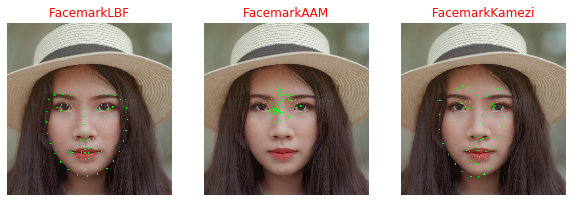

In [47]:
# 3種演算法
    # FacemarkLBF
    # FacemarkAAM
    # FacemarkKamezi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# 載入圖片(灰階) shape=(504, 482)
image = cv2.imread("data/face_test.png", 0)
# Find faces
    # 回傳[第一張臉[x, y, w, h], 第二張臉...]
cas = cv2.CascadeClassifier("data/haarcascade_frontalface_alt2.xml")
faces = cas.detectMultiScale(image , 1.5, 5)
print("faces:\n", faces)

# 演算法1：FacemarkLBF
print("\ntesting LBF")
facemark = cv2.face.createFacemarkLBF()
# download from https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
facemark.loadModel("data/lbfmodel.yaml")
# ok代表是否檢測出關鍵點，landmarks1代表所有 68個關鍵點座標 x, y
    # landmarks1=[array shape=(1, 68, 2), ...]
ok, landmarks1 = facemark.fit(image, faces)
print ("landmarks LBF:", ok, len(landmarks1))

# 演算法2：FacemarkAAM
print("\ntesting AAM")
facemark = cv2.face.createFacemarkAAM()
# download from https://github.com/berak/tt/blob/master/aam.xml
facemark.loadModel("data/aam.xml")
ok, landmarks2 = facemark.fit(image, faces)
print ("landmarks AAM:", ok, len(landmarks2))

# 演算法3：FacemarkKamezi
print("\ntesting Kazemi")
facemark = cv2.face.createFacemarkKazemi()
# download from https://github.com/opencv/opencv_3rdparty/tree/contrib_face_alignment_20170818
facemark.loadModel("data/face_landmark_model.dat")
ok, landmarks3 = facemark.fit(image , faces)
print ("landmarks Kazemi:", ok, len(landmarks3))

# Load image
image_BGR1 = cv2.imread("data/face_test.png")
image_BGR2 = image_BGR1.copy()
image_BGR3 = image_BGR1.copy()
# 特徵點 點出來
for p in landmarks1[0][0]:
    cv2.circle(image_BGR1, tuple(p), 2, (0, 255, 0), -1)
for p in landmarks2[0][0]:
    cv2.circle(image_BGR2, tuple(p), 2, (0, 255, 0), -1)
for p in landmarks3[0][0]:
    cv2.circle(image_BGR3, tuple(p), 2, (0, 255, 0), -1)

# 繪圖
plt.figure(figsize=(10, 10))
def show_img_with_matplotlib(color_img, title, pos):
    img_RGB = color_img[:, :, ::-1]
    ax = plt.subplot(1, 3, pos)
    plt.imshow(img_RGB)
    plt.title(title)
    plt.axis('off')
show_img_with_matplotlib(image_BGR1, "FacemarkLBF", 1)
show_img_with_matplotlib(image_BGR2, "FacemarkAAM", 2)
show_img_with_matplotlib(image_BGR3, "FacemarkKamezi", 3)

# MTCNN

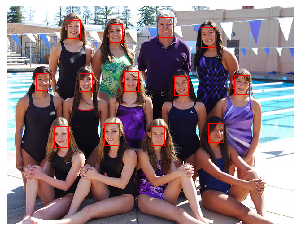

In [3]:
# 臉部 'box'
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle, Circle
from mtcnn.mtcnn import MTCNN
# 載入圖片
filename = 'data/test2.jpg'
pixels = pyplot.imread(filename)

# MTCNN套件辨識
detector = MTCNN()
# 回傳辨識結果=[第1張臉, ..., 第13張臉]
    # 每張臉資訊e.g.
        # {'box': [左上角x, 左上角y, 寬w, 高h],
        #  'confidence': 機率,
        #  'keypoints': {'left_eye': 座標(x, y), 'right_eye': 座標(x, y), 'nose': 座標(x, y), 
        #                'mouth_left': 座標(x, y), 'mouth_right': 座標(x, y)} }
faces = detector.detect_faces(pixels)     # detector.detect_faces(圖片讀入檔案) → 偵測人臉
    
# 繪圖：參數(圖檔路徑, MTCNN辨識結果)
def draw_image_with_boxes(filename, result_list):
    # 載入圖檔
    data = pyplot.imread(filename)
    # 原圖
    pyplot.imshow(data)
    plt.axis('off')
    ax = pyplot.gca()
    # 臉部畫框
    for result in result_list:
        x, y, width, height = result['box']
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        ax.add_patch(rect)
    pyplot.show()
draw_image_with_boxes(filename, faces)

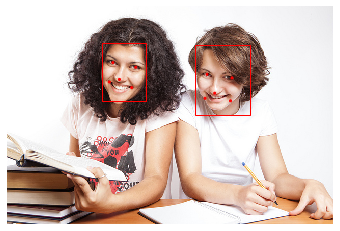

In [7]:
# 關鍵點'keypoints'
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle, Circle
from mtcnn.mtcnn import MTCNN
# 載入圖片
filename = 'data/test1.jpg'
pixels = pyplot.imread(filename)

# MTCNN套件辨識
detector = MTCNN()
faces = detector.detect_faces(pixels)

# 繪圖：參數(圖檔路徑, MTCNN辨識結果)
def draw_image_with_boxes(filename, result_list):
    data = pyplot.imread(filename)
    pyplot.imshow(data)
    plt.axis('off')
    ax = pyplot.gca()
    for result in result_list:
        # 臉部
        x, y, width, height = result['box']
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        ax.add_patch(rect)
        # 關鍵點
        for key, value in result['keypoints'].items():
            dot = Circle(value, radius=2, color='red')
            ax.add_patch(dot)
    pyplot.show()
draw_image_with_boxes(filename, faces)

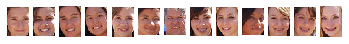

In [8]:
# 辨識出來的人臉 切割取出
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle, Circle
from mtcnn.mtcnn import MTCNN
# 載入圖片
filename = 'data/test2.jpg'
pixels = pyplot.imread(filename)

# MTCNN套件辨識
detector = MTCNN()
faces = detector.detect_faces(pixels)

# 繪圖：參數(圖檔路徑, MTCNN辨識結果)
def draw_faces(filename, result_list):
    data = pyplot.imread(filename)
    # 每張人臉(每個元素)做切割，繪製子圖
    for i in range(len(result_list)):
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        pyplot.subplot(1, len(result_list), i+1)
        pyplot.axis('off')
        pyplot.imshow(data[y1:y2, x1:x2])
    pyplot.show()
draw_faces(filename, faces)